# Analysis of Text Matching Data Generated from JSTOR Dataset
#### Reference version

In [1]:
import pandas as pd
import numpy as np
#import spacy
import re
import json
import altair as alt
#new viz library for single-column heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [2]:
# ACTION: copy path to results JSONL file here (filename should end "_results_[hyperparameters].jsonl")

startData = "/Users/milan/Library/CloudStorage/GoogleDrive-mtt2126@columbia.edu/My Drive/iAnnotate/MIT/Quotable Content/Data/Woolf/1925_Dalloway/Results/Woolf_1925_Dalloway_results_t2-c3-n2-m3-nostops.jsonl"

In [3]:
# Infer naming variables from path

textTitle = startData.rsplit("_", 4)[-3]
publicationYear = startData.rsplit("_", 4)[-4]
authorSurname = startData.rsplit("_", 4)[-5]
authorSurname = authorSurname.rsplit("/", 1)[-1]
hyperparSuffix = startData.rsplit("_", 4)[-1]
hyperparSuffix = f"_{hyperparSuffix[:-6]}"
dataDir = startData.rsplit("/", 4)[0]

print(f"Author surname: {authorSurname}\nPublication year: {publicationYear}\nText title: {textTitle}\nHyperparameters suffix: {hyperparSuffix}\nData directory:{dataDir}")

projectName = f"{authorSurname}_{publicationYear}_{textTitle}"
sourceDir = f"{dataDir}/{authorSurname}/{publicationYear}_{textTitle}/Source"
corpusDir = f"{dataDir}/{authorSurname}/{publicationYear}_{textTitle}/Corpus"
resultsDir = f"{dataDir}/{authorSurname}/{publicationYear}_{textTitle}/Results"

Author surname: Woolf
Publication year: 1925
Text title: Dalloway
Hyperparameters suffix: _t2-c3-n2-m3-nostops
Data directory:/Users/milan/Library/CloudStorage/GoogleDrive-mtt2126@columbia.edu/My Drive/iAnnotate/MIT/Quotable Content/Data


In [4]:
# Load results as pandas dataframe

df = pd.read_json(startData, lines=True)
df

,creator,datePublished,Year,Decade,docSubType,docType,id,identifier,isPartOf,issueNumber,...,volumeNumber,wordCount,numMatches,Locations in A,Locations in B,doi,keyphrase,abstract,placeOfPublication,subTitle
0,[Ellen Tremper],1994-07-01,1994,1990,research-article,article,http://www.jstor.org/stable/3831453,"[{'name': 'issn', 'value': '0022281X'}, {'name...",Journal of Modern Literature,1,...,19,5607,0,[],[],None,None,None,None,None
1,"[Beth Rigel Daugherty, Arnold Weinstein]",2007-01-01,2007,2000,None,document,http://www.jstor.org/stable/24907105,"[{'name': 'doi', 'value': '10.2307/24907105'},...",Woolf Studies Annual,None,...,13,3021,0,[],[],10.2307/24907105,"[weinstein, readers, moderns, woolf faulkner, ...",None,None,None
2,[Christine MacLeod],1997-01-01,1997,1990,book-review,article,http://www.jstor.org/stable/3509206,"[{'name': 'issn', 'value': '03062473'}, {'name...",The Yearbook of English Studies,None,...,27,1210,0,[],[],None,None,None,None,None
3,[Margaret Harris],1973-10-01,1973,1970,None,document,http://www.jstor.org/stable/42946111,"[{'name': 'doi', 'value': '10.2307/42946111'},...",None,3,...,7,9110,4,"[[0, 261], [902, 1418], [1831, 2251], [2957, 2...","[[39742, 40784], [41338, 41854], [42922, 43343...",10.2307/42946111,"[merediths, victors, merediths prose, george m...",Meredith's prose style has frequently been att...,None,None
4,[Frank Baldanza],1958-07-01,1958,1950,research-article,article,http://www.jstor.org/stable/41395513,"[{'name': 'doi', 'value': '10.2307/41395513'},...",None,2,...,12,7337,0,[],[],10.2307/41395513,"[mccullers, miss mccullers, carson mccullers, ...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,"[Mia Carter, ﻣﻴﺎ ﻛﺎﺭﺗﺭ]",2007-01-01,2007,2000,None,document,http://www.jstor.org/stable/30197973,"[{'name': 'doi', 'value': '10.2307/30197973'},...",Alif: Journal of Comparative Poetics,27,...,None,11192,0,[],[],10.2307/30197973,"[woolfs, passionate apprentice, virginia woolf...","This article argues that Woolf's juvenilia, yo...",None,None
2491,"[Shyam M. Asnani, Mulk Raj Anand]",1983-03-01,1983,1980,None,document,http://www.jstor.org/stable/23331532,"[{'name': 'doi', 'value': '10.2307/23331532'},...",Indian Literature,2,...,26,1706,0,[],[],10.2307/23331532,"[indian, mulk raj, raj anand, dobree, british ...",None,None,None
2492,[Susan Stanford Friedman],2013-04-01,2013,2010,None,document,http://www.jstor.org/stable/43653363,"[{'name': 'doi', 'value': '10.2307/43653363'},...",Tulsa Studies in Women's Literature,1,...,32,13023,0,[],[],10.2307/43653363,"[cosmopolitanism, three guineas, persepolis, w...",This comparative essay argues that Virginia Wo...,None,None
2493,[Judith Yaross Lee],2009-01-01,2009,2000,None,document,http://www.jstor.org/stable/42573565,"[{'name': 'doi', 'value': '10.2307/42573565'},...",Studies in American Humor,19,...,None,13888,0,[],[],10.2307/42573565,"[keatons, dialect, vernacular, american, socia...",None,None,None


In [5]:
# Count number of items with/without matches

print(f"Items with matches: {len(df[df['numMatches']>=1])}\nItems without matches: {len(df[df['numMatches']==0])}")

Items with matches: 518
Items without matches: 1977


In [6]:
# Drop items with no matches from dataframe

df = df[df['numMatches']>=1]
df

,creator,datePublished,Year,Decade,docSubType,docType,id,identifier,isPartOf,issueNumber,...,volumeNumber,wordCount,numMatches,Locations in A,Locations in B,doi,keyphrase,abstract,placeOfPublication,subTitle
3,[Margaret Harris],1973-10-01,1973,1970,None,document,http://www.jstor.org/stable/42946111,"[{'name': 'doi', 'value': '10.2307/42946111'},...",None,3,...,7,9110,4,"[[0, 261], [902, 1418], [1831, 2251], [2957, 2...","[[39742, 40784], [41338, 41854], [42922, 43343...",10.2307/42946111,"[merediths, victors, merediths prose, george m...",Meredith's prose style has frequently been att...,None,None
13,[Eleni Coundouriotis],1996-07-01,1996,1990,research-article,article,http://www.jstor.org/stable/3820158,"[{'name': 'issn', 'value': '00345210'}, {'name...",Research in African Literatures,2,...,27,8498,1,"[[174209, 174247]]","[[11190, 11228]]",None,None,None,None,None
20,[Beth C. Schwartz],1991-10-01,1991,1990,research-article,article,http://www.jstor.org/stable/2873462,"[{'name': 'issn', 'value': '00138304'}, {'name...",ELH,3,...,58,11088,1,"[[146124, 146293]]","[[28012, 28559]]",None,None,None,None,None
23,[Karen Kaivola],1998-01-01,1998,1990,None,document,http://www.jstor.org/stable/24906336,"[{'name': 'doi', 'value': '10.2307/24906336'},...",Woolf Studies Annual,None,...,4,10877,2,"[[53836, 53913], [54020, 54055]]","[[46150, 46227], [46239, 46274]]",10.2307/24906336,"[lesbian, identity, sackville wests, sexual id...",None,None,None
26,[David Neal Miller],1972-05-01,1972,1970,None,document,http://www.jstor.org/stable/30225278,"[{'name': 'doi', 'value': '10.2307/30225278'},...",None,2,...,2,3851,7,"[[68337, 68795], [68797, 69056], [255341, 2553...","[[2113, 2571], [2543, 2802], [3984, 4021], [40...",10.2307/30225278,"[authorial, septimus, authorial point, clariss...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,[Teresa Fulker],1995-01-01,1995,1990,None,document,http://www.jstor.org/stable/24906315,"[{'name': 'doi', 'value': '10.2307/24906315'},...",Woolf Studies Annual,None,...,1,11519,19,"[[5199, 5452], [5665, 5928], [13017, 13060], [...","[[34076, 34329], [34343, 34606], [34834, 34877...",10.2307/24906315,None,None,None,None
2477,[R. T. Chapman],1972-10-01,1972,1970,None,document,http://www.jstor.org/stable/26279210,"[{'name': 'doi', 'value': '10.2307/26279210'},...",Modern Fiction Studies,3,...,18,3219,2,"[[10753, 10795], [10865, 10906]]","[[5066, 5108], [5156, 5197]]",10.2307/26279210,"[virginia woolfs, isabella, isabella tyson, lo...",None,None,None
2481,[Keith A. Dickson],1973-01-01,1973,1970,research-article,article,http://www.jstor.org/stable/3726209,"[{'name': 'issn', 'value': '00267937'}, {'name...",The Modern Language Review,1,...,68,8469,1,"[[174199, 174266]]","[[86, 151]]",None,None,None,None,None
2488,[Emily James],2017-09-01,2017,2010,research-article,article,http://www.jstor.org/stable/26806792,"[{'name': 'doi', 'value': '10.2307/26806792'},...",Twentieth Century Literature,3,...,63,11873,3,"[[35058, 35158], [204926, 204980], [298713, 29...","[[12282, 12379], [22771, 22825], [62217, 62372]]",10.2307/26806792,"[inkblot, blotting paper, modernist inkblot, w...",This essay explores the inkblot as a modernist...,None,None


In [7]:
# Display table with journal counts

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df["isPartOf"].value_counts())

Woolf Studies Annual                                                                          66
Modern Fiction Studies                                                                        45
Journal of Modern Literature                                                                  32
Twentieth Century Literature                                                                  26
NOVEL: A Forum on Fiction                                                                     16
Studies in the Novel                                                                          10
ELH                                                                                            7
Criticism                                                                                      7
Critical Inquiry                                                                               7
Contemporary Literature                                                                        6
Tulsa Studies in Women's Liter

In [8]:
inputText = f"{sourceDir}/{projectName}_plaintext.txt"
with open(inputText) as f: 
    txt = f.read()

In [16]:
textALength = len(txt)
print(textALength)

359167


In [10]:
# Get page locations
pageMatches = txt.split('~')
pageMatches = [match.strip() for match in pageMatches]
len(pageMatches)

1

## How many articles do we have published in each year? 

In [10]:
alt.Chart(df).mark_bar().encode(x='Year', y='count()').properties(width=1000)

alt.Chart(...)

# Divide text into chunks

1758
0 427
1 291
2 107
3 136
4 154
5 100
6 167
7 130
8 69
9 177


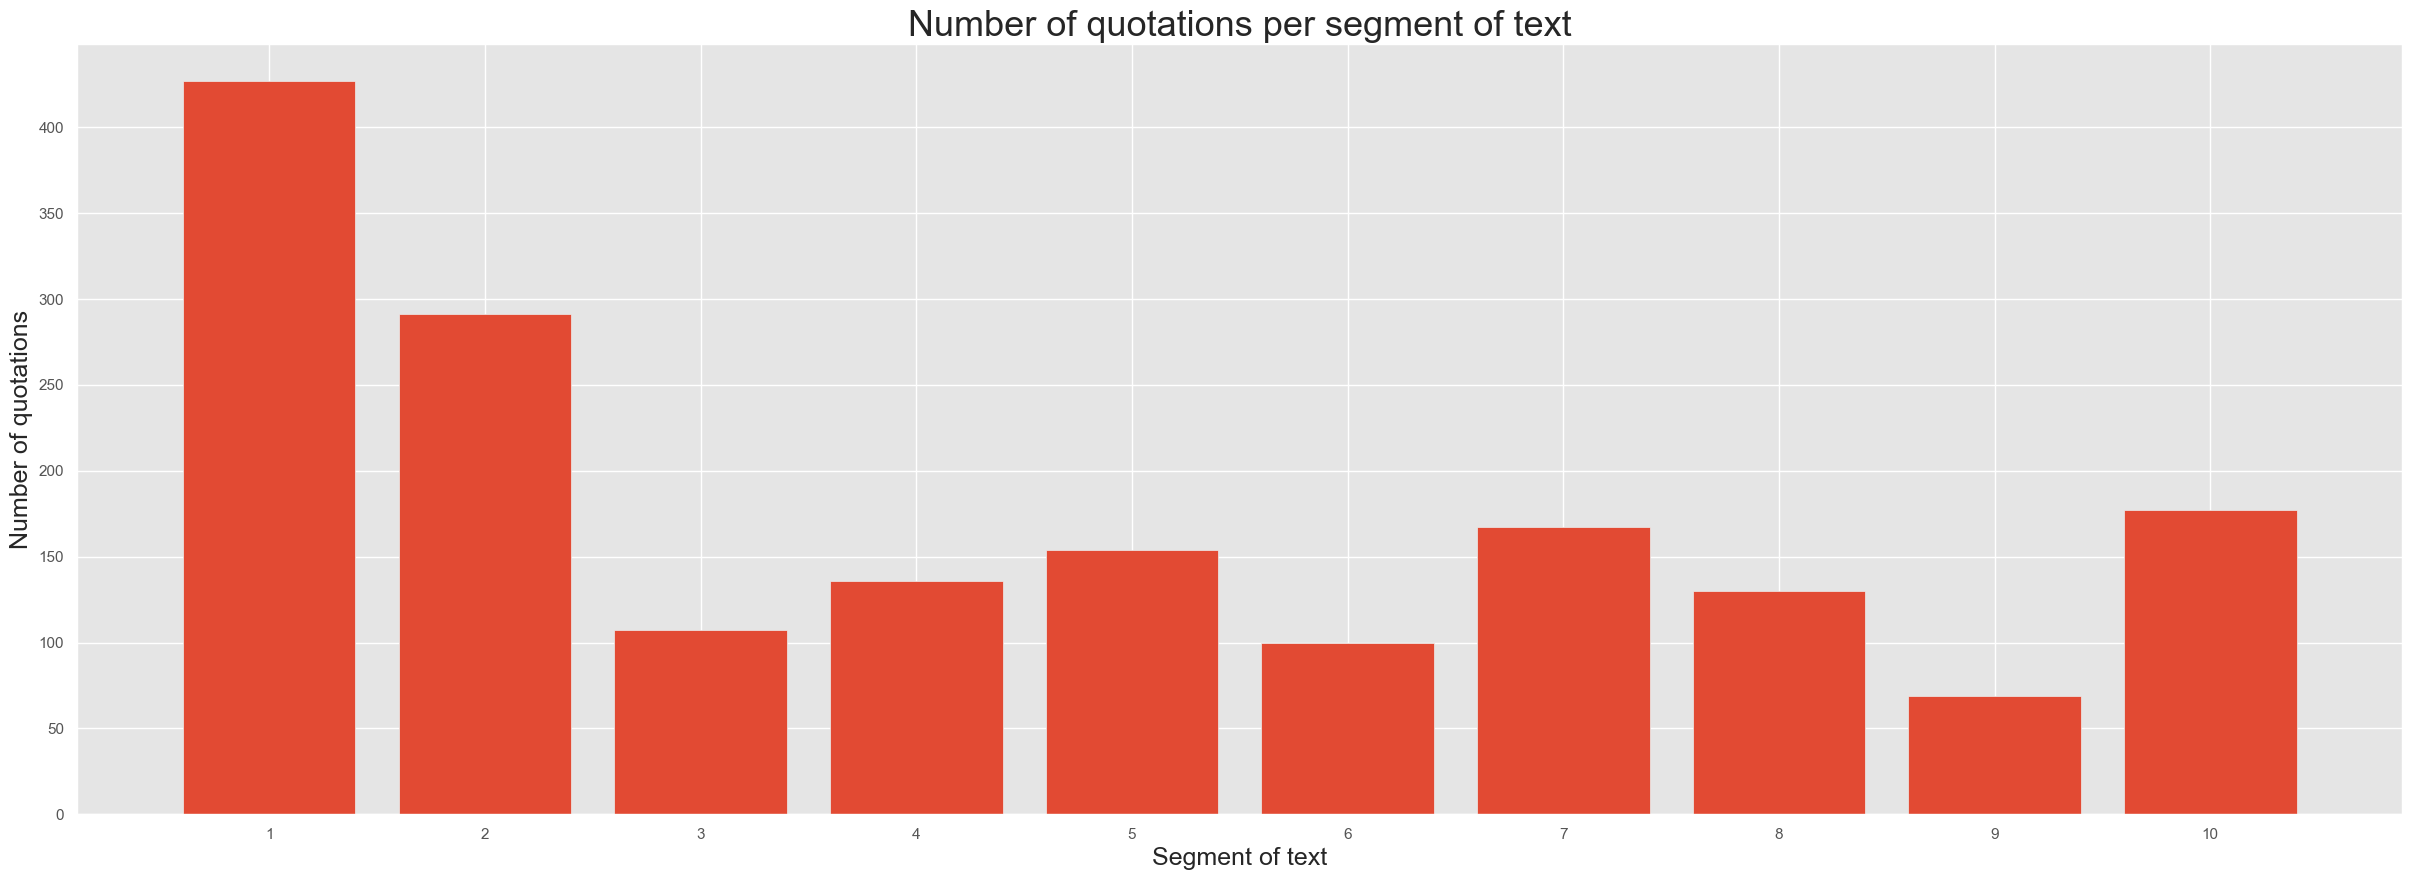

In [30]:
def divideBySections(amount):
    text_occurrence, rangeBreakdown, xLabels = {}, [], []

    for i in range(0, amount):
        text_occurrence[str(i)] = 0
        rangeBreakdown.append(((textALength/amount)*(i), (textALength/amount)*(i+1)))
        xLabels.append(f"{i+1}")

    return text_occurrence, rangeBreakdown, xLabels

def plotPortionsOfQuotes(amount):

    text_occurrence, rangeBreakdown, xLabels = divideBySections(amount)

    for index, row in df.iterrows():
        for (quot_start,quot_end) in row['Locations in A']:
            for index,values in enumerate(rangeBreakdown):
                if (values[0]<=quot_start<=values[1]):
                    text_occurrence[str(index)] += 1

    total_occ = sum(text_occurrence.values())
    print(total_occ)
    for (key, val) in text_occurrence.items():
        print(key,val)


    plt.figure(facecolor='white')
    plt.bar(range(len(text_occurrence)), list(text_occurrence.values()),tick_label=xLabels)

    plt.xlabel("Segment of text")
    plt.ylabel("Number of quotations")
    plt.rcParams["figure.figsize"] = (30,10)
    plt.rcParams.update({'font.size': 18})
    plt.title("Number of quotations per segment of text")

    plt.show()


distributionCount = 10
plotPortionsOfQuotes(distributionCount)

# Average Numbers of Quoted Words Per Item

In [38]:
df['Quoted Words'].describe()

KeyError: 'Quoted Words'

In [ ]:
articlesWithMatches['Quoted Words'].describe()

In [ ]:
len(df[df['Quoted Words'] > 0])

In [ ]:
articlesWithMatches['Quoted Words'].hist()

## Stats about Wordcounts

Average number of words per match, per item: 

In [ ]:
articlesWithMatches['Wordcounts'].apply(np.mean).head()

In [ ]:
articlesWithMatches['Wordcounts'].apply(np.mean).describe()

#### Functions for extracting wordcounts, numbers of quotations for diachronic and synchronic analysis

In [ ]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True, normalize=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts.copy()
        else: 
            decadeDict[decade] += locationsAndWordcounts.copy()
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    if normalize: 
        decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    chunk = mm[locRange[0]:locRange[1]]
    return len(chunk.split())

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')
        
def plotSynchronicAnalysisHeatmap(s, useWordcounts=True): 
    vec1=synchronicAnalysis(df, useWordcounts=False)
    fig, ax = plt.subplots()
    sns.color_palette("magma")
    sns.heatmap([vec1])
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Quotations')
    
def plotDiachronicAnalysisBubble(df, save=False, reverse=False):
    ylabels = [str(int(decade)) for decade in df.index] + ['2020'] 
    alt.Chart(df).mark_circle().encode(
    x='Chapter',
    y='Decade',
    size='sum(count):Q'
)

In [ ]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [ ]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [ ]:
# Verify that the diachronic wordcounts are the same as the synchronic wordcounts
decadeSums = diachronicAnalysis(df, decades=(1700, 2020), useWordcounts=True, normalize=False).sum(axis=1)
decadeSums.sum()

In [ ]:
chapterSums = synchronicAnalysis(df)
chapterSums.sum()

# Quotation Length Statistics

In [ ]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [ ]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

In [ ]:
pd.Series(wordcounts).hist()

# Number of Quotes (and words Quoted) by Chapter

In [ ]:
plotSynchronicAnalysis(synchronicAnalysis(df))

In [ ]:
synchronicAnalysis(df, useWordcounts=True).to_csv('../papers/spring2017-middlemarch-paper/data/num-words-quoted-per-chapter.csv')

### Total number of matches

In [ ]:
allMatches = []
for group in df['Locations in A'].values: 
    for pair in group: 
        allMatches.append(pair)

In [ ]:
len(allMatches)

In [ ]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

In [ ]:
quotationsPerChapter = synchronicAnalysis(df, bins=chapterLocations, useWordcounts=False)
quotationsPerChapter

In [ ]:
quotationsPerChapter = pd.DataFrame(quotationsPerChapter, index=range(0,88), columns=['Number of Quotations'])
quotationsPerChapter['Chapter'] = range(0, 88)
quotationsPerChapter

In [ ]:
alt.Chart(quotationsPerChapter).mark_circle().encode(x='Chapter:O', size='Number of Quotations:Q').properties(width=1000, height=150)

In [ ]:
alt.Chart(quotationsPerChapter).mark_circle().encode(x='Chapter:O', size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=1000, height=150)

In [ ]:
# Redo chart with horizontal labels
alt.Chart(quotationsPerChapter).mark_circle().encode(x=alt.X('Chapter:Q', axis=alt.Axis(title="Chapter", tickMinStep=5,
                                       labelOverlap=False,labelAngle=0)), 
size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=1000,height=150).configure_legend(
    titleFontSize=9,
    labelFontSize=10
)

In [ ]:
alt.Chart(quotationsPerChapter).mark_circle().encode(y='Chapter:O', size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=150)

## Quotations Per Book

In [ ]:
quotationsPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=False)
quotationsPerBook

In [ ]:
quotationsPerBook = pd.DataFrame(quotationsPerBook, index=range(1,9), columns=['Number of Quotations'])
quotationsPerBook['Book'] = range(1, 9)
quotationsPerBook

In [ ]:
alt.Chart(quotationsPerBook).mark_bar().encode(x='Book:O', y='Number of Quotations:Q').properties(width=500)

In [ ]:
alt.Chart(quotationsPerBook).mark_circle().encode(x='Book:O', size=alt.Size('Number of Quotations:Q')).properties(height=150).configure_legend(
titleFontSize=9,
labelFontSize=10
) 

In [ ]:
# Redo chart with horizontal labels
alt.Chart(quotationsPerBook).mark_circle().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0,)), 
size=alt.Size('Number of Quotations:Q')).properties(height=150).configure_legend(
    titleFontSize=9,
    labelFontSize=10
)

## Raw Number of Quotations Per Chapter

In [ ]:
# Get the raw number of quotations per chapter
# synchronicAnalysis(df, useWordcounts=False).to_csv('../papers/spring2017-middlemarch-paper/data/num-quotations-per-chapter.csv')

In [ ]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

In [ ]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations).sort_index())

In [ ]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index())

In [ ]:
# Create a one-dimensional heatmap of the synchonic raw number of quotations per chapter, as heatmap
vec1=synchronicAnalysis(df, useWordcounts=False)
fig, ax = plt.subplots()
sns.color_palette("magma")
sns.heatmap([vec1])
ax.set_xlabel('Chapter')
ax.set_ylabel('Number of Quotations')

In [ ]:
# Create a one-dimensional heatmap of the synchonic raw number of quotations per chapter, as heatmap
# INVERTED COLOR SCHEMA
vec1=synchronicAnalysis(df, useWordcounts=False)
fig, ax = plt.subplots()
sns.heatmap([vec1], cmap = 'magma_r')
ax.set_xlabel('Chapter')
ax.set_ylabel('Number of Quotations')

In [ ]:
diaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index()

In [ ]:
diaDFquoteOnly = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=False, normalize=False).sort_index()

In [ ]:
plotDiachronicAnalysisBubble(diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index())

In [ ]:
synDF = synchronicAnalysis(df, useWordcounts=False)

In [ ]:
synDF.index.name = 'chapter'

In [ ]:
synDF

## Redo chart in Altair

In [ ]:
diaDF.columns.name = 'chapter'
diaDF.index.name = 'decade'

In [ ]:
diaDF

In [ ]:
# Redo with raw quotations, not normalized by decade
diaDFquoteOnly.columns.name ='chapter'
diaDFquoteOnly.index.name = 'decade'

In [ ]:
diaDFquoteOnly

In [ ]:
diaDF.columns

In [ ]:
diaDF['decade'] = diaDF.index

In [ ]:
diaMelted = diaDF.melt(id_vars='decade')

In [ ]:
diaDFquoteOnly['decade'] = diaDFquoteOnly.index

In [ ]:
diaDFquoteOnlyMelted = diaDFquoteOnly.melt(id_vars='decade')

In [ ]:
alt.Chart(diaMelted).mark_rect().encode(x='chapter:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="# of Quotations (normalized)"))).properties(width=1000, height=300).configure(background='#eeeeeeff')

In [ ]:
alt.Chart(diaMelted).mark_circle().encode(x='chapter:O', y='decade:O', size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=9,
labelFontSize=10
) 

In [ ]:
#Redo Chart to rotate tick marks
alt.Chart(diaMelted).mark_circle().encode(
    x=alt.X('chapter:Q', axis=alt.Axis(tickMinStep=5,
                                       labelOverlap=False,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=9,
labelFontSize=10
) 

In [ ]:
#Chart with raw quotations
alt.Chart(diaDFquoteOnlyMelted).mark_rect().encode(x='chapter:O', y='decade:O', color='value').properties(width=1000, height=300)

In [ ]:
alt.Chart(diaDFquoteOnlyMelted).mark_circle().encode(x='chapter:O', y='decade:O', size='value').properties(width=1000, height=300)

In [ ]:
booksDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations).sort_index()
booksDiaDF

In [ ]:
booksDiaDF['decade'] = booksDiaDF.index

In [ ]:
booksMelted = booksDiaDF.melt(id_vars='decade', var_name='book')

In [ ]:
booksMelted.head()

In [ ]:
booksMelted = booksMelted[booksMelted.book != 0]
booksMelted

In [ ]:
alt.Chart(booksMelted).mark_rect().encode(x='book:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="# of Quotations (normalized)"))).properties(width=500, height=300).configure(background='#eeeeeeff')

In [ ]:
alt.Chart(booksMelted).mark_circle().encode(x='book:O', y='decade:O', size='value').properties(width=500, height=300)

In [ ]:
alt.Chart(booksMelted).mark_circle().encode(x='book:O', y='decade:O', size=alt.Size('value', legend=alt.Legend(title="Number of Quotations (normalized)"), scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=9,
labelFontSize=10
) 

In [ ]:
#Redo Chart to rotate tick marks
alt.Chart(booksMelted).mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=9,
labelFontSize=10
) 

In [ ]:
def plotDiachronicAnalysisBooks(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Book')
    plt.gca().set_xlim((1, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()

plotDiachronicAnalysisBooks(diachronicAnalysis(df, decades=(1950, 2020), bins=bookLocations).sort_index())

In [ ]:
# Export image for publication
# plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations), save=True)

In [ ]:
# Get the normalized proportion of, say, Chapter 20 in 1950: 
diachronicAnalysis(df)[20][1950]

# By (Guessed) Gender of Author

In [ ]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

In [ ]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [ ]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

In [ ]:
# Differences in citations between genders. 
plotSynchronicAnalysis(synchronicAnalysis(dfM) - synchronicAnalysis(dfF))

# By (Guessed) Country of Publication

In [ ]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [ ]:
publishers = topPublishers[:80].index

In [ ]:
publishers = publishers.tolist()

In [ ]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [ ]:
df['country'] = df['publisher_name'].apply(getCountry)

In [ ]:
df['country'].value_counts()

In [ ]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [ ]:
# Since British authors are greatly outnumbered in this corpus, we should normalize the data. 
britsHist = synchronicAnalysis(dfBrits) 
normBrits = britsHist.div(britsHist.max())
yanksHist = synchronicAnalysis(dfYanks)
normYanks = yanksHist.div(yanksHist.max())

In [ ]:
plotSynchronicAnalysis(normYanks - normBrits)

# By Journal

In [ ]:
# Look at the top journals. 
journalStats = df['journal'].value_counts()
journalStats[:10]

In [ ]:
journalList = journalStats.index

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [ ]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [ ]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

In [ ]:
fig = plt.figure()
ax = (normGE - normOther).plot(kind='bar')
fig.add_subplot(ax)
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')
# Save a big version for publication. 
fig.savefig('specialization.png', bboxinches='tight', dpi=300)

In [ ]:
journals = pd.DataFrame({title: synchronicAnalysis(df.loc[df['journal'] == title]) for title in journalList }).T

In [ ]:
cutoff = 1500
topJournals = journals.loc[journals.sum(axis=1) > cutoff]
otherJournals = journals.loc[journals.sum(axis=1) < cutoff]
topJournals.loc['Other'] = otherJournals.sum()

In [ ]:
topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')

In [ ]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
fig = ax.get_figure()
fig.savefig('synchronic-journals.png', bboxinches='tight', dpi=300)

In [ ]:
# Print the total number of journals
len(journalStats)

# Detour: Ch. 15

In [ ]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 322052: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [ ]:
# Get the titles of those articles. 
[item.title for item in chap15s]

In [ ]:
ch15Topics =  [item.topics for item in chap15s]
chap15TopicsFlat = [item for sublist in ch15Topics for item in sublist]
Counter(chap15TopicsFlat).most_common(20)

In [ ]:
xvStart, xvEnd = chapterLocations[15:17]

In [ ]:
print(mm[xvStart:xvStart+1000]) 

In [ ]:
# Try to find out which articles cite the first 2/3 of Chapter XV (with Lydgate's scientific research) 
# vs the last 1/3 on the story of Laure
chap15p1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 313892: # Does it cite the first 2/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p1s.append(row)
                    ids.append(row.id)
chap15p2s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 313892 and start < 322052: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p2s.append(row)
                    ids.append(row.id)                   
                    

In [ ]:
# Get the titles of articles citing the first 2/3 
[item.title for item in chap15p1s]

In [ ]:
# Get the titles of those articles. 
[item.title for item in chap15p2s]

In [ ]:
# Verify that we have the right location for the start of Laure's story in the last 1/3 of Chapter XV
print(mm[313892:313892+1500]) 

In [ ]:
# Verify the location of the eipgraph and first paragraph
print(mm[290371:290371+1571]) 

In [ ]:
chap15para1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 291943: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15para1s.append(row)
                    ids.append(row.id)    

In [ ]:
# Get the titles of articles that cite paragraph 1 of Chapter 15
[item.title for item in chap15para1s]

In [ ]:
chap15Lydgates = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 291942 and start < 313892: # Does it cite the first 2/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15Lydgates.append(row)
                    ids.append(row.id)
                    
# Get the titles of articles that cite Lydgate section
[item.title for item in chap15Lydgates]

# Chapter 20

Chapter 20 Detour


In [ ]:
# Try to find out what articles cited chapter 20 
chap20s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 406324 and start < 432778: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20s.append(row)
                    ids.append(row.id)


In [ ]:
# Get the titles of those articles. 
[item.title for item in chap20s]

In [ ]:
# articlesWithoutMatches.title #Print the titles of articles without matches


In [ ]:
len(chap20s)

In [ ]:
# Try to find out what articles cite paragraph 6 in Chapter 20
chap20par6s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 411152 and start < 412177: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20par6s.append(row)
                    ids.append(row.id)


In [ ]:
# Get the titles of those articles.
[item.title for item in chap20par6s]

In [ ]:
len(chap20par6s) # The number of items citing paragraph 6 in chapter 20

In [ ]:
xxStart, xxEnd = chapterLocations[20:22] # Chapter 20 Boundaries

In [ ]:
print(mm[xxStart:xxStart+1000]) # Verify we have Ch. 20

In [ ]:
xx = mm[xxStart:xxEnd]

In [ ]:
xxParaLocations = [match.start() for match in re.finditer('\n\n+', mm)]
xxParaLocations = [x for x in xxParaLocations if (x > xxStart) and (x < xxEnd)] 

In [ ]:
mm[xxParaLocations[4]:xxParaLocations[5]]

In [ ]:
articlesWithMatches['Locations in A'].loc[0]

In [ ]:
def inXX(matches): 
    """ Determine if the article has a match in Ch. 20"""
    for match in matches: 
        if match[0] > xxStart and match[0] < xxEnd:
            return True
    return False

In [ ]:
articlesWithMatches['Locations in A'].apply(inXX).head()

In [ ]:
def paraIndicesIn20(matches, paraLocations=xxParaLocations): 
    """ Determine paragraph number (index) for match in Ch. 20. """
    paraIndices = []
    if inXX(matches): 
        paraBoundaries = list(zip(paraLocations, paraLocations[1:]))
        for match in matches: 
            for i, paraBoundary in enumerate(paraBoundaries): 
                if set(range(match[0], match[1])) & set(range(paraBoundary[0], paraBoundary[1])): # find the set intersection of the ranges of pairs
                    paraIndices.append(i)
                else: 
                    paraIndices.append(None)
    return paraIndices
                    
                

In [ ]:
len(set(range(8, 10)) & set(range(1, 9)))

In [ ]:
articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)

In [ ]:
counters = list(articlesWithMatches['paraIndicesIn20'].apply(Counter))

In [ ]:
grandTally = Counter()

In [ ]:
for counter in counters: 
    grandTally += counter

In [ ]:
del grandTally[None]

In [ ]:
dict(grandTally)

In [ ]:
pd.Series(dict(grandTally)).sort_index().plot(kind='bar')

In [ ]:
print(mm[xxParaLocations[5]:xxParaLocations[7]]) # What are paragraphs #5 and #6? 

# NLH, ELH and GE-GHL

## George Eliot - George Henry Lewes Studies

### George Eliot - George Henry Lewes Studies articles where journal title is "George Eliot - George Henry Lewes Studies"

In [ ]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']

In [ ]:
pd.set_option('display.max_columns', 207)

In [ ]:
geJournals 

In [ ]:
print(geJournals.title)

In [ ]:
print("Number of George ELiot - George Henry Lewes Studies articles where journal title is 'George ELiot - George Henry Lewes Studies':")
len(geJournals)

### George Eliot - George Henry Lewes Studies articles where journal code is "georelioghlstud"

In [ ]:
print("Number of George Eliot - George Henry Lewes Studies articles where journal code is 'georelioghlstud':")
geJournalCodes = df.loc[df['jcode'].str[0] == 'georelioghlstud']
len(geJournalCodes)

## NLH

### NLH articles where journal title is "New Literary History"

In [ ]:
nlhJournals = df.loc[df['journal'] == 'New Literary History']

In [ ]:
pd.set_option('display.max_rows', 300)

In [ ]:
nlhJournals 

In [ ]:
print("Number of NLH articles where journal title is 'New Literary History':")
len(nlhJournals)

### NLH articles where journal code is "newlitehist"

In [ ]:
print('NLH articles where journal code is "newlitehist":')
nlhJournalCodes = df.loc[df['jcode'].str[0] == 'newlitehist']
len(nlhJournalCodes)

## ELH

### ELH articles where journal title is "ELH"

In [ ]:
elhJournals = df.loc[df['journal'] == 'ELH']
elhJournals

In [ ]:
len(elhJournals)

### ELH articles where journal code is "elh"

In [ ]:
elhJournalCodes = df.loc[df['jcode'].str[0] == 'elh']
len(elhJournalCodes)

# Nonmatches

In [ ]:
df # Print the dataframe

In [ ]:
df[df.title.apply(isGarbage)] # How many garbage items? 

In [ ]:
# Try to find out what articles contain no Middlemarch citations
articlesWithoutMatches = df[df['Locations in A'].apply(lambda x: len(x) == 0)]


In [ ]:
n = 10
articlesWithoutMatches['title'].value_counts()[:n].index.tolist()

In [ ]:
# What is the most frequent name of articles with no citations?
articlesWithoutMatches['title'].describe()

## Generating samples of dataset for evaluating the precision and recall of text matcher
First, we're going to generate a smaller sample dataset, which we'll then perform bootstrapping on.

First, let's stratify our dataset by year, and then take a random sample in that year.

In [ ]:
articlesWithMatches1960_2015 = articlesWithMatches[articlesWithMatches['Decade'] >= 1960]
len(articlesWithMatches1960_2015)

In [ ]:
len(articlesWithMatches1960_2015['year'].value_counts())

### Generate random sample

In [ ]:
sampleData = articlesWithMatches1960_2015.sample(n=56, random_state=56)
sampleData['journal'].value_counts(sort=False)

In [ ]:
sampleData.to_csv('../data/sample_dataset.csv', encoding='utf-8')

In [ ]:
# Function to loop over each row, extracting locations in A and metadata, then output that to a new text file
def extractSampleDataMatches(sampleData):
    for i, row in sampleData.iterrows():
        title = row['title']
        year = row['year']
        # Print a break between each article
        with open('../data/sample-data-matches.txt', "a") as f:
            print("---------------------------------------\n", file=f)
            print(title, file=f)
            print(year, file=f)
        # For each pair of locations in the "Locations in A" column, iterate over, printing the location indexes
        # Followed by the
            for pair in row['Locations in A']:
                print(f"Location in A: {pair}", file=f)
                print(mm[pair[0]:pair[1]]+"\n", file=f)
    
extractSampleDataMatches(sampleData)

### Evaluation metrics

Terminology
TP (True Positives):
TN (True Negatives): 
FP (False Posiives): 
FN (False Negatives): 

**Classification accuracy:** percentage of correctly identified quotes and non-quotes, or overall, how often is the matcher correct? classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)))

 **Recall (or "sensitivity")**: When the actual match is correc, how often is the prediction correct? recall = TP / float(FN + TP)


**Precision:** When a match is detected, how often is that match correct? precision = TP / float(TP + FP)
